In [182]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import ETFs as etfs

In [153]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# display(data)

In [154]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)

## Test data correctness

In [155]:
test_df = pd.DataFrame({'Close_yesterday': data['SPY'].shift(1),'Close Tody':data['SPY'],'Target': binary_targets['SPY']})
display(test_df)

,Close_yesterday,Close Tody,Target
Date,,,
2012-01-03,NaN,100.450684,0
2012-01-04,100.450684,100.608261,1
2012-01-05,100.608261,100.876129,1
2012-01-06,100.876129,100.616127,0
2012-01-09,100.616127,100.860359,1
...,...,...,...
2025-03-24,563.979980,574.080017,1
2025-03-25,574.080017,575.460022,1
2025-03-26,575.460022,568.590027,0


In [156]:

def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
        
        y_target = df.iloc[i+window_size] / first_value  
        y.append(y_target.values)
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_values.append(first_value.values) 
        
    X = np.array(X)
    y = np.array(y)
    first_values = np.array(first_values)
    labels = np.array(labels)
    return X, y, first_values, labels



In [157]:
window_size = 30
dataset_size = len(data)
train_size = int(dataset_size * 0.8)
test_size = 30 + window_size
val_size = dataset_size - train_size - test_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]


X_train, y_train, first_values_train, labels_train = create_X_y_rolling(train_data, binary_targets_train, window_size)
X_val, y_val, first_values_val, labels_val = create_X_y_rolling(val_data, binary_targets_val, window_size)
X_test, y_test, first_values_test, labels_test = create_X_y_rolling(test_data, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape


((2696, 30, 33),
 (2696, 33),
 (592, 30, 33),
 (592, 33),
 (30, 30, 33),
 (30, 33),
 (2696, 33),
 (592, 33),
 (30, 33))

In [159]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)),
    Dropout(0.3), 

    LSTM(64, return_sequences=False),
    Dropout(0.4),  

    Dense(labels_train.shape[1], activation='sigmoid'),
])


model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001),   
              metrics=['binary_accuracy',])

cp = ModelCheckpoint(filepath='model_binary/best_binary.keras', 
                     save_best_only=True, monitor='val_loss', 
                     mode='min')

es = EarlyStopping(
    monitor='val_binary_accuracy',        
    patience=10,                
    restore_best_weights=True 
)

history = model.fit(
    X_train, labels_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, labels_val),
    callbacks=[cp, es],
)
# model.summary()




Epoch 1/100


c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - binary_accuracy: 0.5239 - loss: 0.7523 - val_binary_accuracy: 0.5014 - val_loss: 0.7652
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - binary_accuracy: 0.5568 - loss: 0.7290 - val_binary_accuracy: 0.5014 - val_loss: 0.7684
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - binary_accuracy: 0.5556 - loss: 0.7223 - val_binary_accuracy: 0.5002 - val_loss: 0.7670
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - binary_accuracy: 0.5529 - loss: 0.7169 - val_binary_accuracy: 0.5020 - val_loss: 0.7646
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - binary_accuracy: 0.5536 - loss: 0.7128 - val_binary_accuracy: 0.5010 - val_loss: 0.7631
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - binary_accuracy: 0.5512 - loss: 0.7086 - val_binary_accuracy: 0.4974 - val_loss: 0.7598
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - binary_accuracy: 0.5501 - loss: 0.7089 - val_binary_accuracy: 0.4999 - val_loss: 0.7596
Epoch 8/100
43/43 

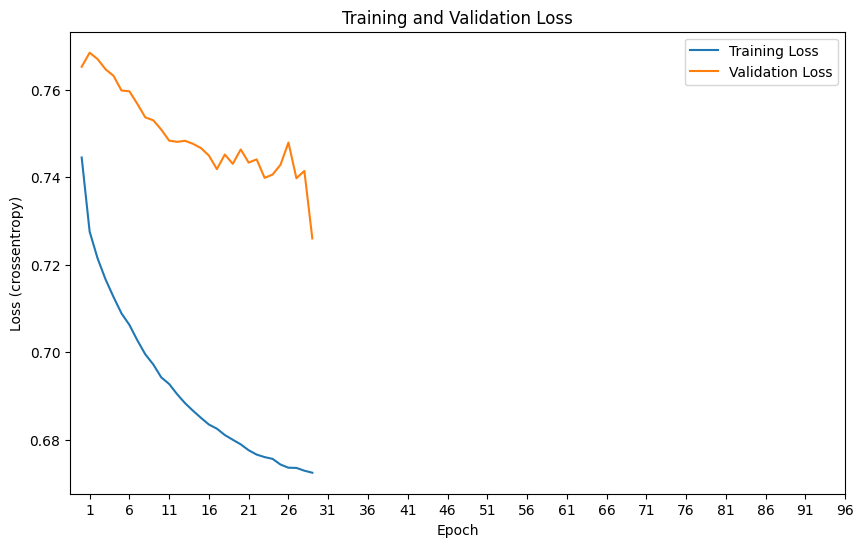

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (crossentropy)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

In [161]:
# from sklearn.metrics import f1_score, precision_score, recall_score

# # Flatten predictions and ground truth
# y_val_pred = model.predict(X_val)
# # print(y_val_pred)
# y_val_pred_binary = (y_val_pred > 0.5).astype(int)
# print("F1:", f1_score(y_val.flatten(), y_val_pred_binary.flatten()))
# print("Precision:", precision_score(y_val.flatten(), y_val_pred_binary.flatten()))
# print("Recall:", recall_score(y_val.flatten(), y_val_pred_binary.flatten()))


In [191]:
model = load_model('model_binary/best_binary.keras')
index_series = data.index[-len(y_test):]

y_pred = model.predict(X_test)
# display(y_pred)

y_pred_classes = (y_pred > 0.5).astype(int)

Predict_result_df = pd.DataFrame(y_pred_classes, index=index_series, columns=data.columns)


# display(Predict_result_df)
print("F1:", f1_score(y_pred_classes.flatten(), labels_test.flatten()))
print("Precision:", precision_score(y_pred_classes.flatten(), labels_test.flatten()))
print("Recall:", recall_score(y_pred_classes.flatten(), labels_test.flatten()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
F1: 0.5025432349949135
Precision: 0.5393013100436681
Recall: 0.4704761904761905


In [ ]:
# labels_test

In [181]:
from sklearn.metrics import accuracy_score

actual_flat = labels_test.flatten()
predicted_flat = Predict_result_df.to_numpy().flatten()
accuracy = accuracy_score(actual_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.5061


In [177]:
average = Predict_result_df
display(average)
num_ones = (average == 1).sum()
num_zeros = (average == 0).sum()
y_pred_mean = (num_ones > num_zeros).astype(int)
y_pred_mean_df = pd.DataFrame(y_pred_mean, index = Predict_result_df.columns, columns=['Predicted Trend'])
display(y_pred_mean_df.T)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-02-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-02-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-02-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-02-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-02-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-02-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-02-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-02-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Predicted Trend,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
yesterday_prices = data.iloc[-2] 
today_prices_actual = data.iloc[-1] 
y_actual = binary_targets.iloc[-1] 
today_taget_predicted = pd.Series(y_pred_mean, index=Predict_result_df.columns)

comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_actual_target': y_actual,
    'Today_pred_target': y_pred_mean,
})


tickers_names = binary_targets.columns

correct_list = []
for ticker in tickers_names:
    predict = today_taget_predicted[ticker]
    actual = y_actual[ticker]
    if predict == actual:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
# display(comparison_df)
save_df = pd.DataFrame()
save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today actual target'] = comparison_df['Today_actual_target'].apply(lambda x: round(x, 2))
save_df['Today pred target'] = comparison_df['Today_pred_target'].apply(lambda x: round(x, 2))
save_df['Correct'] = comparison_df['Correct']
display(save_df)
save_df.to_csv('rnn_binary_6.csv', index=False)

Count of correct predictions: 30
accuracy: 0.9090909090909091


,Yesterday actual,Today actual,Today actual target,Today pred target,Correct
AIEQ,37.66,36.85,0,0,1
ASHR.L,10.46,10.34,0,0,1
BCHN.L,97.08,92.71,0,0,1
CORN,18.51,18.46,0,0,1
DBO,14.13,13.97,0,0,1
EDEN,105.33,105.17,0,0,1
EMXC,56.11,55.18,0,0,1
EWA,23.75,23.47,0,0,1
EWC,41.25,40.57,0,0,1
EWG,37.59,37.39,0,0,1
